# Statistical Analysis of Cardiac DNA Synthesis Experiment

------------------------

Welcome to this tutorial on statistical analysis using R. In this notebook, we'll work through an experiment designed to test whether the neurotransmitter **norepinephrine** controls the formation of cardiac muscle cells in rats. This analysis will guide you through data loading, visualization, outlier detection, and various statistical tests, including t-tests and ANOVA.

## Learning Objectives

After completing this tutorial, you will be able to:

1. Load and inspect a dataset in R.
2. Visualize data using box plots and line graphs.
3. Detect and handle outliers appropriately.
4. Perform t-tests and interpret p-values.
5. Conduct ANOVA (Analysis of Variance) tests.
6. Understand and interpret interaction effects in ANOVA.
7. Apply ANCOVA (Analysis of Covariance) to control for confounding variables.

---

Let's get started!

## 1. Experiment Description

**Background:**

- Cardiac muscle cells are formed during development and then permanently exit the mitotic cycle.
- The experiment aims to test whether **norepinephrine** controls the formation of these cells.
- Rats were studied from birth to 19 days of postnatal (PN) age, covering the progression from mitotic to postmitotic growth.

**Experimental Design:**

- On PN1 (Postnatal Day 1), pups received an injection of either **saline** (control) or **6-hydroxydopamine (6OHDA)**, a neurotoxin that destroys norepinephrine neurons.
- At various ages, mitotic activity in the heart was measured by injecting animals with radiolabeled thymidine.
- After 30 minutes, tissues were analyzed for the amount of radiolabel incorporated into DNA relative to total uptake, providing an index of mitotic activity.
- **Negative Controls:**
  - **Liver DNA Synthesis:** Measured in the same animals to check if the effect is specific to the heart.
  - **Protein Synthesis:** Measured in additional pups to see if the effect is specific to DNA synthesis.
- **Measurements:**
  - **Body Weight**
  - **Heart DNA Synthesis (heart incorp/uptake)**
  - **Liver DNA Synthesis (liver incorp/uptake)**

**Questions to Answer:**

1. Does 6OHDA affect the mitotic activity of developing cardiac muscle cells?
2. Is the effect specific to the heart (i.e., not shared by the liver)?
3. Is the effect specific to DNA synthesis (i.e., not shared by protein synthesis)?
4. Is the effect on cardiac DNA synthesis an artifact of reduced body weight caused by 6OHDA?

---

## 2. Load Packages and Data

First, we'll load the necessary packages and import the dataset.

In [1]:
# Suppress warnings and messages
options(warn=-1)
options(jupyter.plot_mimetypes = 'image/png')


# Install and load required packages
if (!require(tidyverse)) install.packages("tidyverse")
if (!require(readxl)) install.packages("readxl")
if (!require(rstatix)) install.packages("rstatix")
if (!require(patchwork)) install.packages("patchwork")




library(tidyverse)
library(readxl)
library(rstatix)
library(patchwork)
library(IRdisplay)


Loading required package: tidyverse

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: readxl

Loading required package: rstatix

also installing the dependencies ‘rbibutils’, ‘cowplot’, ‘Deriv’, ‘microbenchmark’, ‘Rdpack’, ‘doBy’, ‘SparseM’, ‘MatrixModels’, ‘minqa’, ‘nloptr’, ‘reformulas’, ‘carData’, ‘abind’, ‘Formula’, ‘pbkrtest’, ‘quantreg’, ‘lme4’, ‘corrplot’, ‘car’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Loading required package: patchwork

Updatin

### 2.1 Load the Dataset

Assuming you have the dataset `set1.xlsx`, make sure it's in your working directory. Let's read the data into R.

In [2]:
# Read the Excel file
data.df <- read_excel("assets/data/set1.xlsx")

# View first few rows of data
head(data.df)

Animal ID,PN1 Rx,age,synthesis,cohort,#,bdy wt (g),heart incorp/uptake,liver incorp/uptake
<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,control,PN3,dna,a,1,8.7,0.2558699,0.5520949
2,control,PN3,dna,a,2,9.5,0.3540678,0.6638080
3,control,PN3,dna,a,3,8.6,0.2121922,0.5070101
4,control,PN3,dna,a,4,9.2,0.1684247,0.4421059
5,control,PN3,dna,a,5,7.3,0.3101163,0.5732143
6,control,PN3,dna,b,1,9.9,0.4291962,0.5995576


### 2.2 Inspect the Data

Let's check the structure and summary of the data to understand what we're working with.

In [3]:
# Check the structure of the data
show(data.df)



# A tibble: 199 × 9
   `Animal ID` `PN1 Rx` age   synthesis cohort   `#` `bdy wt (g)`
         <dbl> <chr>    <chr> <chr>     <chr>  <dbl>        <dbl>
 1           1 control  PN3   dna       a          1          8.7
 2           2 control  PN3   dna       a          2          9.5
 3           3 control  PN3   dna       a          3          8.6
 4           4 control  PN3   dna       a          4          9.2
 5           5 control  PN3   dna       a          5          7.3
 6           6 control  PN3   dna       b          1          9.9
 7           7 control  PN3   dna       b          5         10.1
 8           8 control  PN3   dna       b          9         10  
 9           9 control  PN3   dna       b         13          9.3
10          10 control  PN3   dna       b         17         10  
# ℹ 189 more rows
# ℹ 2 more variables: `heart incorp/uptake` <dbl>, `liver incorp/uptake` <dbl>


## Preparing Data for Analysis: Step-by-Step Data Cleaning

First, let's take a look at what we need to accomplish:
1. Create consistent column names
2. Set appropriate data types
3. Organize our columns logically

### 1. Creating Consistent Column Names
First, let's change the column names to something more consistent and easy to work with. R works best with simple, descriptive names that:
- Use lowercase letters
- Replace spaces with underscores (snake_case)
- Avoid special characters
- Clearly describe the content

In [4]:
clean_data.df <- data.df %>%
 rename(
   animal_id = "Animal ID",
   treatment = "PN1 Rx",
   body_weight_g = "bdy wt (g)",
   heart_ratio = "heart incorp/uptake",
   liver_ratio = "liver incorp/uptake",
   sample_number = "#"
 )


### 2. Converting Data Types
Next, we need to tell R how to interpret our data columns. This is crucial because:
- Factors tell R that a variable is categorical (like treatment groups)
- Numeric values are needed for calculations
- Ordered factors maintain correct sequence (like age groups)

In [5]:
clean_data.df <- clean_data.df %>%
 mutate(
   age_days = parse_number(age),          # Extract numbers from age
   age_factor = fct_reorder(age, parse_number(age)),  # Order age groups correctly
   treatment = factor(treatment),         # Treatment groups are categories
   synthesis = factor(synthesis),         # Type of measurement is categorical
   cohort = factor(cohort)               # Experimental batches are categories
 )


### 3. Organizing Columns
Finally, let's arrange our columns in a logical order to make our data frame easier to work with:

In [6]:
clean_data.df <- clean_data.df %>%
 select(
   animal_id, treatment, cohort,          # Identifying information
   age_days, age_factor, synthesis,       # Experimental variables
   sample_number, body_weight_g,          # Additional measurements
   heart_ratio, liver_ratio              # Our main outcome variables
 )


### 4. Verify Our Work
Always good practice to check the cleaned dataset:

In [7]:
clean_data.df

animal_id,treatment,cohort,age_days,age_factor,synthesis,sample_number,body_weight_g,heart_ratio,liver_ratio
<dbl>,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,control,a,3,PN3,dna,1,8.7,0.2558699,0.5520949
2,control,a,3,PN3,dna,2,9.5,0.3540678,0.6638080
3,control,a,3,PN3,dna,3,8.6,0.2121922,0.5070101
4,control,a,3,PN3,dna,4,9.2,0.1684247,0.4421059
5,control,a,3,PN3,dna,5,7.3,0.3101163,0.5732143
6,control,b,3,PN3,dna,1,9.9,0.4291962,0.5995576
7,control,b,3,PN3,dna,5,10.1,0.3508016,0.5488010
8,control,b,3,PN3,dna,9,10.0,0.3136901,0.4919004
9,control,b,3,PN3,dna,13,9.3,0.3573709,0.4776865


Remember: Proper data cleaning and type setting is crucial for subsequent statistical analysis. Incorrect data types can lead to errors or misleading results in your analysis.

### Same code as above, but we can also combine into one step using pipes %>%

In [8]:
clean_data.df <- data.df %>%
  # Clean column names using consistent snake_case
  rename(
    animal_id = "Animal ID",
    treatment = "PN1 Rx",
    body_weight_g = "bdy wt (g)",
    heart_ratio = "heart incorp/uptake",
    liver_ratio = "liver incorp/uptake",
    sample_number = "#"
  ) %>%
  # Clean up data types and age
  mutate(
    age_days = parse_number(age),
    age_factor = fct_reorder(age, parse_number(age)),
    treatment = factor(treatment),
    synthesis = factor(synthesis),
    cohort = factor(cohort)
  ) %>%
  # Reorganize columns logically
  select(
    animal_id, treatment, cohort,
    age_days, age_factor, synthesis,
    sample_number, body_weight_g,
    heart_ratio, liver_ratio
  )



## Using Boxplots to Visualize Data Distribution

Boxplots (also called box-and-whisker plots) provide a concise visualization of data distribution. Here's what they show:

- The **box** spans from the first quartile (Q1, 25th percentile) to the third quartile (Q3, 75th percentile)
- The **line** in the box represents the median
- The **whiskers** extend to show the rest of the distribution
- **Points** beyond the whiskers indicate potential outliers (values > 1.5 × IQR from the box edges)

Let's create a boxplot to visualize heart uptake ratios for DNA synthesis:

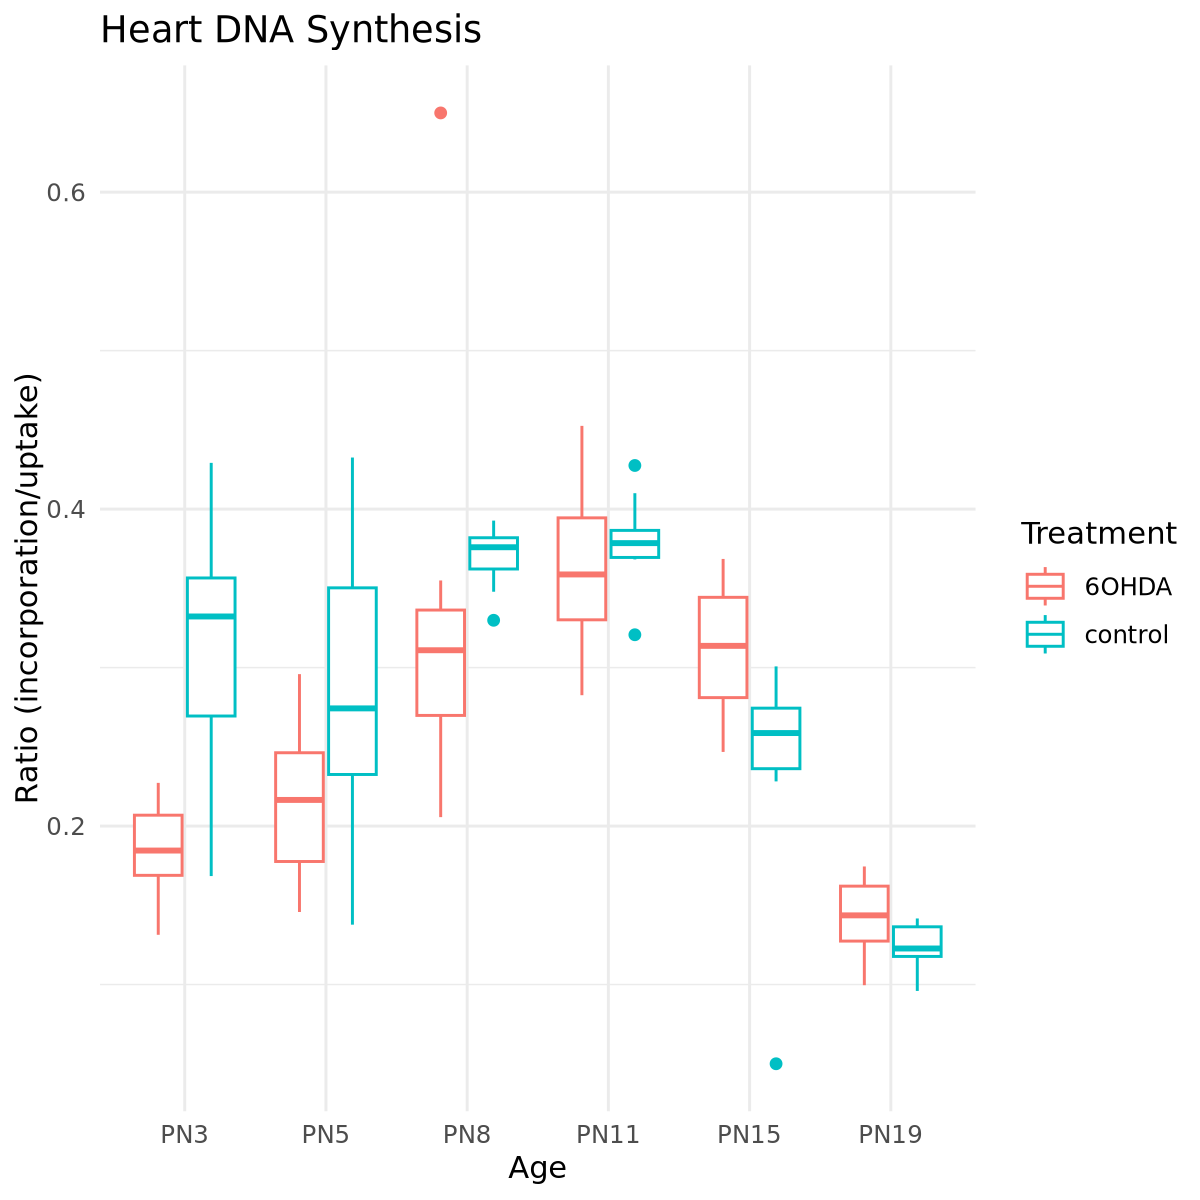

In [9]:
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res=200)

# Heart DNA
clean_data.df %>%
  filter(synthesis == "dna") %>%
  ggplot(aes(x = age_factor, y = heart_ratio, color = treatment)) +
  geom_boxplot() +
  theme_minimal() +
  labs(title = "Heart DNA Synthesis",
       x = "Age",
       y = "Ratio (incorporation/uptake)",
       color = "Treatment")


Now try creating the same boxplot for liver DNA synthesis.


In [ ]:
# Enter your code here


<details>
<summary><strong>Hint:</strong> Click to expand</summary>

The code will be very similar - you'll just need to:
- Replace heart_ratio with liver_ratio
- Update the plot title to reflect liver synthesis
- Update axis labels as needed

</details>



<details>
<summary><strong>Solution:</strong> Click to expand</summary>  

```r  
options(repr.plot.width = 6, repr.plot.height = 5, repr.plot.res=200)

# Liver DNA
clean_data.df %>%
 filter(synthesis == "dna") %>%
 ggplot(aes(x = age_factor, y = liver_ratio, color = treatment)) +
 geom_boxplot() +
 coord_cartesian(ylim = c(0, NA)) +  # Force 0 at bottom, auto-scale top
 theme_minimal() +
 labs(title = "Liver DNA Synthesis",
      x = "Age",
      y = "Ratio (incorporation/uptake)",
      color = "Treatment")
```

</details>

## Make a composite plot of all the different measurements

heart protein ratio, heart DNA ratio, liver protein ratio, liver DNA ratio, body weight

### Using Patchwork to Create Multi-Panel Figures

The patchwork package provides an elegant way to combine multiple ggplot objects. The syntax is intuitive:
- `+` places plots side by side
- `/` places plots one above the other
- Parentheses `()` group plots together

For our five plots, we want this layout:

```text
+----------+----------+
|    p1    |    p2    |  Heart (DNA & Protein)
+----------+----------+
|    p3    |    p4    |  Liver (DNA & Protein)
+----------+----------+
|         p5          |  Body Weight
+----------+----------+
```

The code `(p1 + p2) / (p3 + p4) / p5` creates this arrangement:
1. `p1 + p2` puts heart plots side by side
2. `p3 + p4` puts liver plots side by side
3. The `/` operators stack these rows
4. Final `/p5` puts body weight plot at bottom

Key patchwork operators:
- `+` : side by side
- `/` : top to bottom
- `|` : add a plot independently
- `()` : group plots together

We use `plot_layout(heights = c(1, 1, 1))` to make all rows equal height.



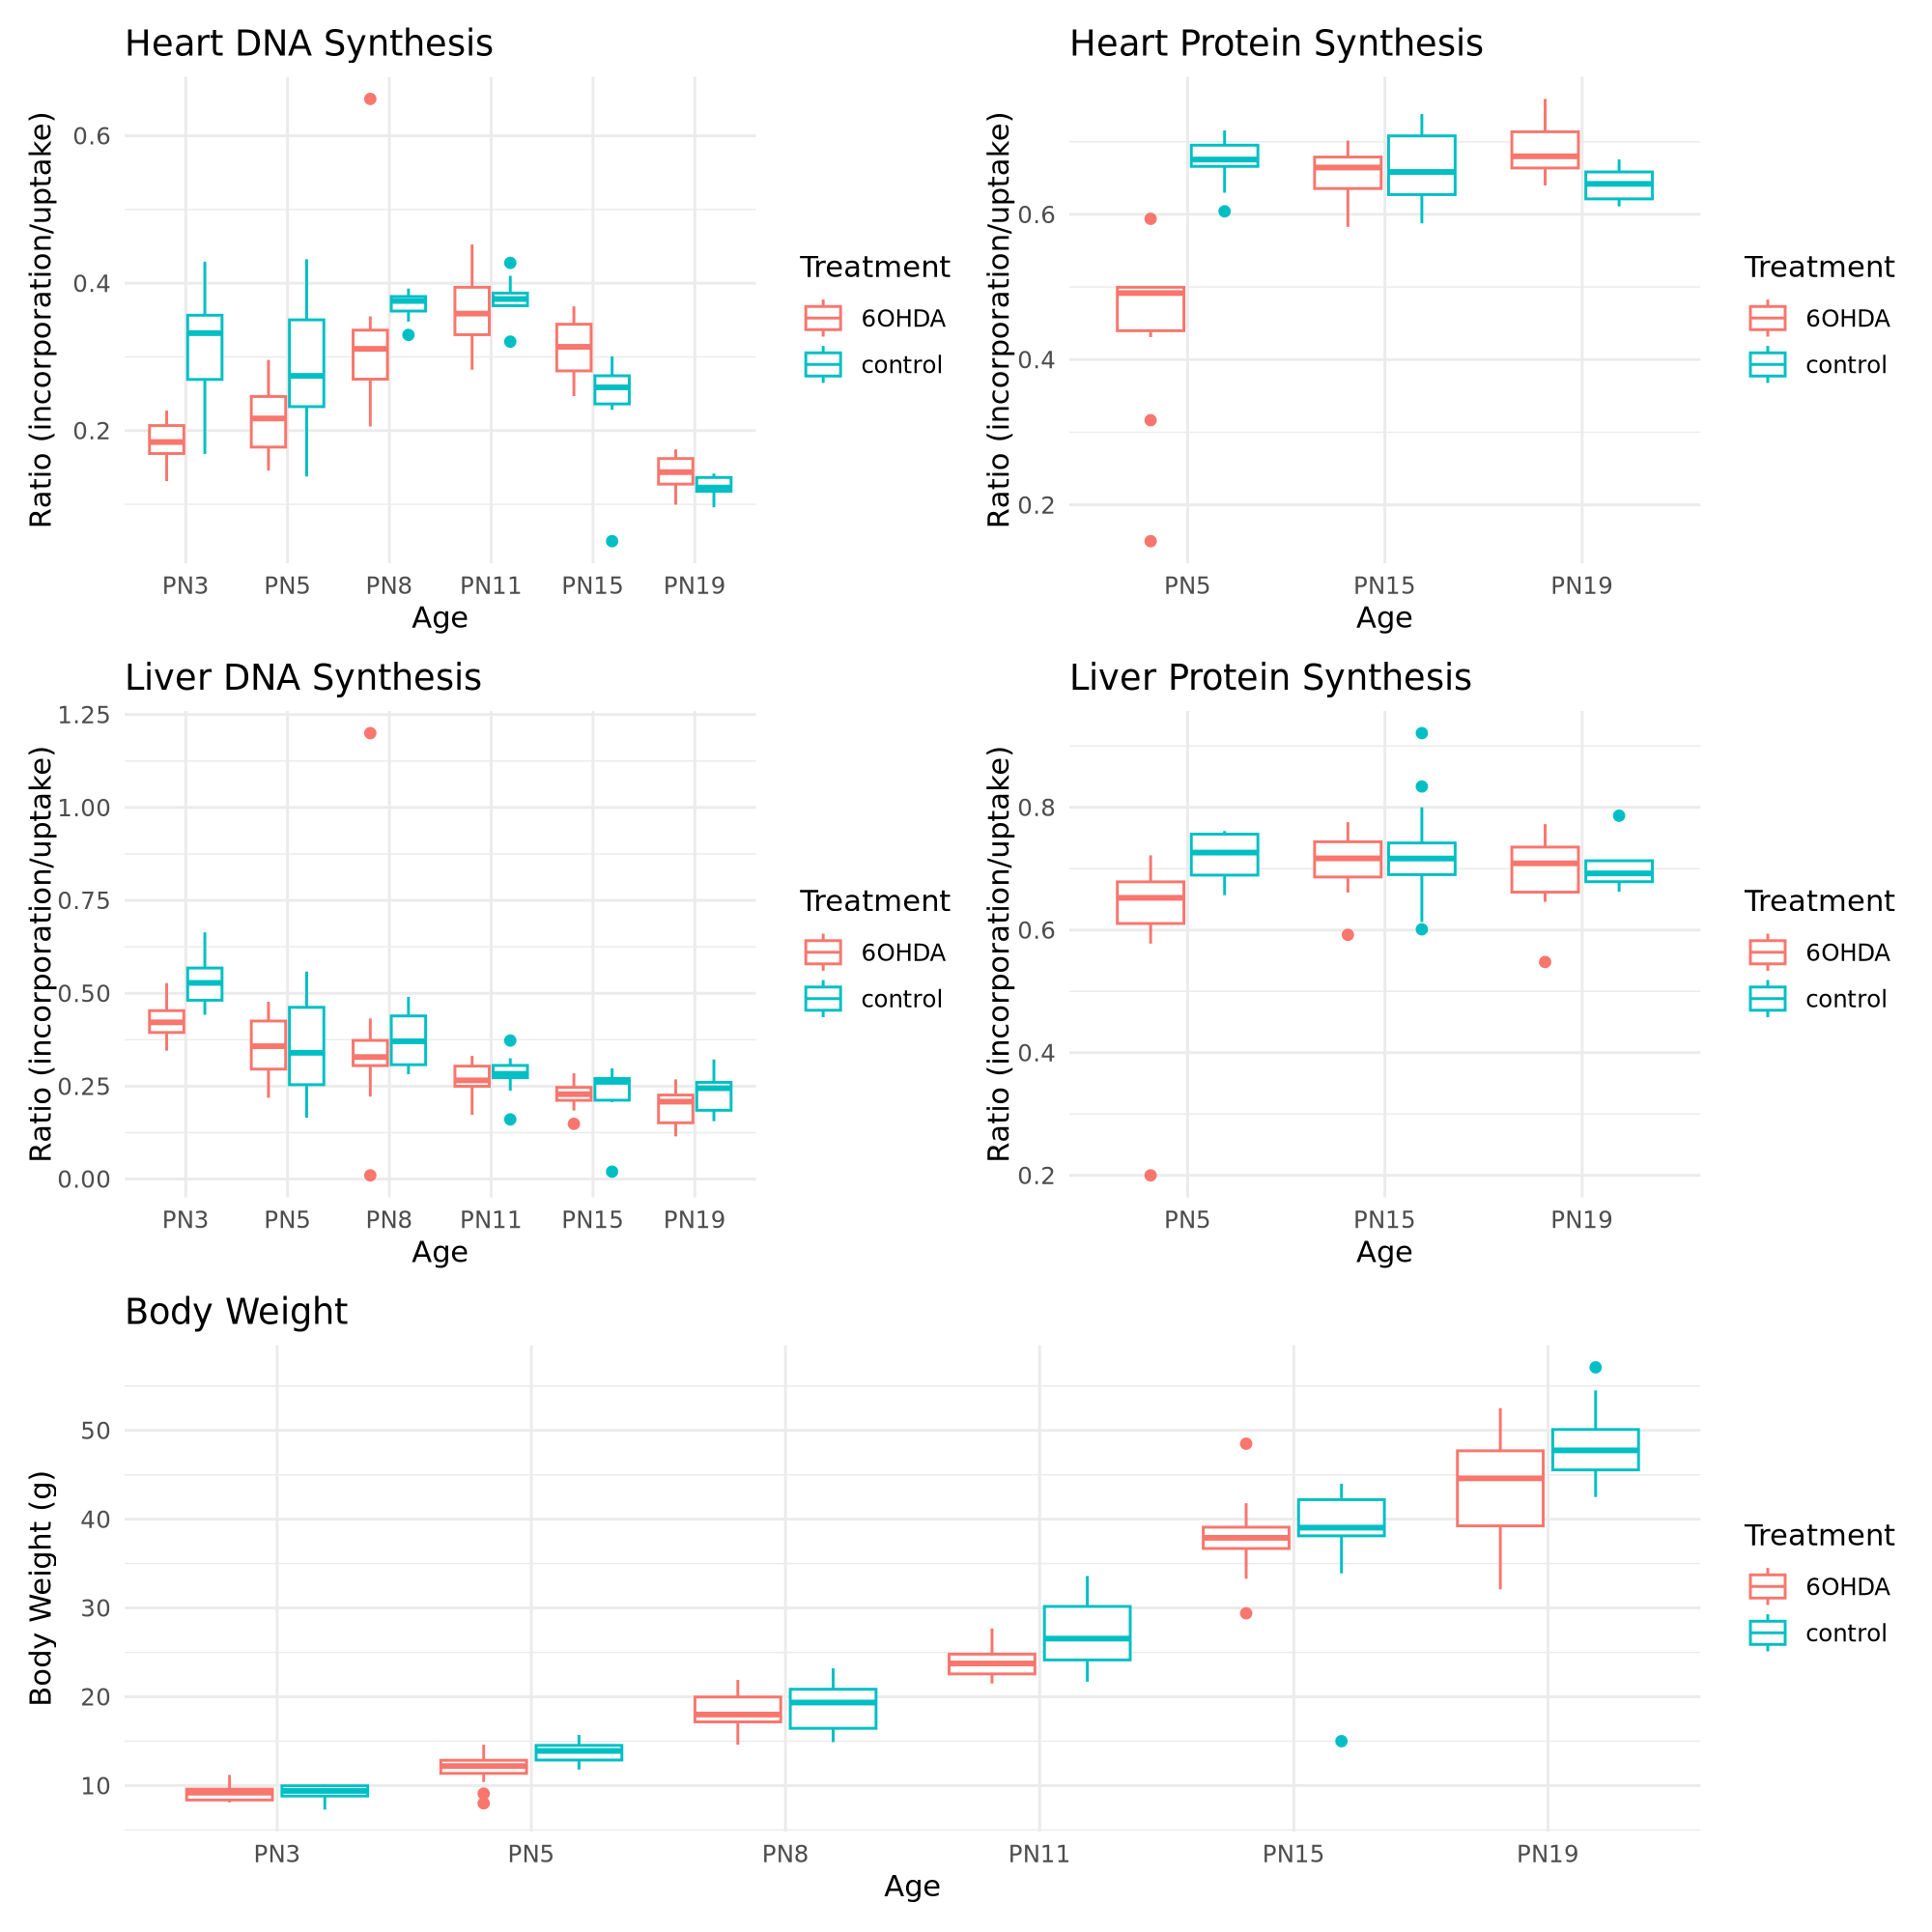

In [10]:
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res=200)

# Heart DNA
p1 <- clean_data.df %>%
  filter(synthesis == "dna") %>%
  ggplot(aes(x = age_factor, y = heart_ratio, color = treatment)) +
  geom_boxplot() +
  theme_minimal() +
  labs(title = "Heart DNA Synthesis",
       x = "Age",
       y = "Ratio (incorporation/uptake)",
       color = "Treatment")

# Heart Protein
p2 <- clean_data.df %>%
  filter(synthesis == "protein") %>%
  ggplot(aes(x = age_factor, y = heart_ratio, color = treatment)) +
  geom_boxplot() +
  theme_minimal() +
  labs(title = "Heart Protein Synthesis",
       x = "Age",
       y = "Ratio (incorporation/uptake)",
       color = "Treatment")

# Liver DNA
p3 <- clean_data.df %>%
  filter(synthesis == "dna") %>%
  ggplot(aes(x = age_factor, y = liver_ratio, color = treatment)) +
  geom_boxplot() +
  theme_minimal() +
  labs(title = "Liver DNA Synthesis",
       x = "Age",
       y = "Ratio (incorporation/uptake)",
       color = "Treatment")

# Liver Protein
p4 <- clean_data.df %>%
  filter(synthesis == "protein") %>%
  ggplot(aes(x = age_factor, y = liver_ratio, color = treatment)) +
  geom_boxplot() +
  theme_minimal() +
  labs(title = "Liver Protein Synthesis",
       x = "Age",
       y = "Ratio (incorporation/uptake)",
       color = "Treatment")

# Body Weight
p5 <- clean_data.df %>%
  ggplot(aes(x = age_factor, y = body_weight_g, color = treatment)) +
  geom_boxplot() +
  theme_minimal() +
  labs(title = "Body Weight",
       x = "Age",
       y = "Body Weight (g)",
       color = "Treatment")

# Arrange plots using patchwork
(p1 + p2) / (p3 + p4) / p5 +
  plot_layout(heights = c(1, 1, 1))

## Understanding Statistical Outliers in Biological Data

#### The Box Plot Method and Biological Context
While statistical methods can identify potential outliers, biological data requires careful consideration beyond pure mathematics. The common box plot method provides a starting point, but should never be used as the sole criterion for data exclusion.

#### Statistical Detection Basics
The box plot method uses these key components:
- Q1: The 25th percentile
- Q3: The 75th percentile
- IQR: The Interquartile Range (Q3 - Q1)

Potential outlier boundaries are calculated as:
- Lower Boundary = Q1 - (1.5 × IQR)
- Upper Boundary = Q3 + (1.5 × IQR)

#### Critical Considerations for Biological Data
When evaluating potential outliers in biological data, consider:

1. **Biological Plausibility**
  - Is the value physically or biologically possible?
  - Example: Synthesis ratios cannot exceed 1.0
  - Values outside known biological limits warrant investigation

2. **Systematic Patterns**
  - Look for consistent patterns across multiple measurements
  - Example: An animal showing consistently small measurements across all parameters may be a runt, not an outlier
  - Single unusual measurements from otherwise normal samples need special scrutiny

3. **Technical vs. Biological Variation**
  - Technical outliers: Values that are impossible or result from clear measurement errors
  - Biological outliers: Unusual but potentially valid biological variation
  - Technical outliers can be removed with more confidence than biological outliers

#### Best Practices for Outlier Analysis

1. **Document Everything**
  - Record all criteria used for outlier identification
  - Note specific justification for each excluded datapoint
  - Maintain transparency in publications about outlier handling

2. **Conservative Approach**
  - Only remove data points when you have strong biological or technical justification
  - Consider reporting results both with and without outliers
  - Be especially cautious with small sample sizes

3. **Multiple Methods**
  - Use statistical methods (like `identify_outliers` in rstatix) as screening tools only
  - Combine statistical analysis with biological expertise
  - Consider consulting subject matter experts for unusual cases

#### Warning Signs That Merit Investigation
- Values outside physically possible ranges
- Measurements that deviate drastically from established literature
- Technical readings beyond instrument capabilities
- Systematic differences across all measurements from a single subject
- Unexplainable extreme values that don't fit known biological mechanisms

Remember: It's better to include a potential outlier than to incorrectly exclude valid biological variation. Statistical outlier detection should guide investigation, not automatically determine exclusion.

In [11]:
# First let's look at just heart ratio for DNA synthesis
heart_outliers <- clean_data.df %>%
  group_by(synthesis, age_factor, treatment) %>%
  identify_outliers(heart_ratio)

heart_outliers

treatment,age_factor,synthesis,animal_id,cohort,age_days,sample_number,body_weight_g,heart_ratio,liver_ratio,is.outlier,is.extreme
<fct>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
6OHDA,PN8,dna,55,a,8,18,17.9,0.6500000,0.0100000,TRUE,TRUE
control,PN8,dna,48,b,8,9,20.7,0.3298443,0.3299738,TRUE,FALSE
control,PN11,dna,63,a,11,9,25.5,0.3207155,0.2377459,TRUE,FALSE
control,PN11,dna,72,b,11,5,33.6,0.4275297,0.3727674,TRUE,FALSE
control,PN15,dna,81,a,15,1,15.0,0.0500000,0.0200000,TRUE,TRUE
6OHDA,PN5,protein,131,c,5,2,12.2,0.5939279,0.6063353,TRUE,FALSE
6OHDA,PN5,protein,133,c,5,6,13.4,0.3165495,0.7217317,TRUE,FALSE
6OHDA,PN5,protein,139,c,5,18,8.0,0.1500000,0.2000000,TRUE,TRUE
control,PN5,protein,126,c,5,11,14.1,0.6042284,0.7318309,TRUE,FALSE


Now try to identify outliers in liver_ratio using the same approach we used for heart_ratio.


In [ ]:
# Type code here`



<details> <summary><strong>Hint:</strong> Click to expand</summary>  

You'll need to:
- Keep the same grouping structure
- Replace heart_ratio with liver_ratio
- Save to a new variable name (e.g., liver_outliers)

</details>

<details> <summary><strong>Solution:</strong> Click to expand</summary>   

```r
# Look at liver ratio outliers for DNA synthesis
liver_outliers <- clean_data.df %>%
 group_by(synthesis, age_factor, treatment) %>%
 identify_outliers(liver_ratio)

liver_outliers
```

</details>

# Efficient Outlier Detection Using Long Format Data

When working with multiple physiological measurements per animal (heart_ratio, liver_ratio, body_weight_g), converting data to long format enables more precise outlier handling. The key advantage is the ability to selectively mark individual measurements as outliers while preserving other valid measurements from the same animal.

## Data Structure Comparison

### Wide Format (Original)
```
| animal_id | heart_ratio | liver_ratio | body_weight_g |
|-----------|-------------|-------------|---------------|
| 1         | 0.25        | 0.55        | 8.7           |
| 2         | 0.35        | 0.66        | 9.5           |
```

In wide format, marking outliers typically means flagging entire rows. This would force us to discard all measurements from an animal even if only one measurement is problematic.

### Long Format (After pivot_longer)
```
| animal_id | measure       | value  |
|-----------|---------------|--------|
| 1         | heart_ratio   | 0.25   |
| 1         | liver_ratio   | 0.55   |
| 1         | body_weight_g | 8.7    |
| 2         | heart_ratio   | 0.35   |
| 2         | liver_ratio   | 0.66   |
| 2         | body_weight_g | 9.5    |
```

In long format, we can mark individual measurements as outliers. When we pivot back to wide format, these marked outliers become NAs in their respective columns, while preserving other valid measurements from the same animal.

## Benefits of Long Format for Outlier Detection

### Precision in Data Retention
The long format approach allows us to be surgical in our outlier handling. For example, if animal_id 1 has an unusual heart_ratio but normal liver_ratio and body_weight, we can:
1. Mark only the heart_ratio measurement as an outlier
2. Preserve the valid liver_ratio and body_weight measurements
3. When pivoting back to wide format, only the heart_ratio becomes NA

### Statistical Robustness
This approach improves our statistical power by:
- Retaining more valid measurements in the final dataset
- Avoiding unnecessary data loss from otherwise good observations
- Maintaining larger sample sizes for analyses where measurements are valid

### Implementation Efficiency
Processing in long format also streamlines our workflow:
- Apply consistent outlier detection criteria across all measurements
- Group by relevant experimental factors (synthesis, age, treatment) for each measure type
- Maintain data integrity while handling anomalies precisely

In [12]:
#Convert data to long format
long_data.df <- clean_data.df %>%
  pivot_longer(
    cols = c(heart_ratio, liver_ratio, body_weight_g),
    names_to = "measure",
    values_to = "value"
  ) %>%
  mutate(measure = factor(measure,
                         levels = c("heart_ratio", "liver_ratio", "body_weight_g"),
                         )
        )

head(long_data.df)

animal_id,treatment,cohort,age_days,age_factor,synthesis,sample_number,measure,value
<dbl>,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>
1,control,a,3,PN3,dna,1,heart_ratio,0.2558699
1,control,a,3,PN3,dna,1,liver_ratio,0.5520949
1,control,a,3,PN3,dna,1,body_weight_g,8.7000000
2,control,a,3,PN3,dna,2,heart_ratio,0.3540678
2,control,a,3,PN3,dna,2,liver_ratio,0.6638080
2,control,a,3,PN3,dna,2,body_weight_g,9.5000000


In [13]:
# Find outliers
long_data.df<-long_data.df %>%
group_by(synthesis, measure, age_factor, treatment) %>%
  mutate(
    is_outlier = is_outlier(value),
    is_extreme = is_extreme(value)
  ) %>%
  ungroup()

In [14]:
# Look at just the outliers
long_data.df %>% filter(is_outlier)

animal_id,treatment,cohort,age_days,age_factor,synthesis,sample_number,measure,value,is_outlier,is_extreme
<dbl>,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<lgl>,<lgl>
48,control,b,8,PN8,dna,9,heart_ratio,0.3298443,TRUE,FALSE
54,6OHDA,a,8,PN8,dna,14,liver_ratio,1.2000000,TRUE,TRUE
55,6OHDA,a,8,PN8,dna,18,heart_ratio,0.6500000,TRUE,TRUE
55,6OHDA,a,8,PN8,dna,18,liver_ratio,0.0100000,TRUE,TRUE
63,control,a,11,PN11,dna,9,heart_ratio,0.3207155,TRUE,FALSE
65,control,a,11,PN11,dna,17,liver_ratio,0.1606030,TRUE,TRUE
72,control,b,11,PN11,dna,5,heart_ratio,0.4275297,TRUE,FALSE
72,control,b,11,PN11,dna,5,liver_ratio,0.3727674,TRUE,FALSE
81,control,a,15,PN15,dna,1,heart_ratio,0.0500000,TRUE,TRUE


# Outlier Analysis Overview

Before removing outliers, we analyze their patterns to distinguish between technical anomalies and potentially meaningful biological variations. This analysis helps identify:

1. Individual animals with multiple outlier measurements, which could indicate:
   - Biological phenomena (e.g., developmentally delayed "runts")
   - Systematic measurement errors affecting multiple organs
   - Sample handling issues during processing

2. Technical outliers that likely represent measurement errors:
   - Organ-to-body ratios greater than 1 (physically impossible)
   - Inconsistencies between adjacent measurements
   - Values far outside the expected physiological range

## Implementation Approach

The code below creates a summary of outliers by:
1. Calculating interquartile ranges (IQR) within each experimental group
2. Showing the extreme outliers relative to these ranges
3. Counting multiple outliers per animal
4. Preserving contextual information (treatment, age, cohort) for interpretation

This summary allows us to:
- Review outliers in their experimental context
- Identify animals with multiple anomalous measurements
- Make informed decisions about outlier handling based on biological plausibility

The resulting `outlier_summary` dataframe provides a comprehensive view of potential outliers while maintaining the relationship between different measurements from the same animal.

In [15]:
# Create group-based outlier summary
group_outlier_summary <- long_data.df %>%
 # First get the IQR stats for each group
 group_by(treatment, age_factor, measure, synthesis) %>%
 mutate(
   q1 = quantile(value, 0.25),
   q3 = quantile(value, 0.75),
   iqr = q3 - q1
 ) %>%
 ungroup() %>%
 # Then filter for extreme outliers and add the counts
 filter(is_extreme) %>%
 select(animal_id, treatment, age_factor, cohort, measure, synthesis,
        value, q1, q3, iqr) %>%
 arrange(animal_id, measure) %>%
 group_by(animal_id) %>%
 mutate(n_outliers = n()) %>%
 ungroup()


group_outlier_summary



animal_id,treatment,age_factor,cohort,measure,synthesis,value,q1,q3,iqr,n_outliers
<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
54,6OHDA,PN8,a,liver_ratio,dna,1.2000000,0.3053777,0.3732271,0.06784933,1
55,6OHDA,PN8,a,heart_ratio,dna,0.6500000,0.2698088,0.3363000,0.06649126,2
55,6OHDA,PN8,a,liver_ratio,dna,0.0100000,0.3053777,0.3732271,0.06784933,2
65,control,PN11,a,liver_ratio,dna,0.1606030,0.2729167,0.3057483,0.03283151,1
81,control,PN15,a,heart_ratio,dna,0.0500000,0.2361953,0.2743922,0.03819686,3
81,control,PN15,a,liver_ratio,dna,0.0200000,0.2122940,0.2706396,0.05834556,3
81,control,PN15,a,body_weight_g,dna,15.0000000,37.4750000,40.6000000,3.12500000,3
139,6OHDA,PN5,c,heart_ratio,protein,0.1500000,0.4398129,0.4996548,0.05984194,3
139,6OHDA,PN5,c,liver_ratio,protein,0.2000000,0.6105942,0.6785117,0.06791755,3


In [16]:
html_content<-readr::read_file("assets/html/outlier_animal.html")
display_html(html_content)

Based on your outlier analysis, which animals should be considered for exclusion?
 
 
 
 Animal 81 and Animal 139
 
 
 Animal 81, Animal 139, and Animal 55
 
 
 Only Animal 81

In [17]:
html_content<-readr::read_file("assets/html/outlier_technical.html")
display_html(html_content)

Based on your outlier analysis, which individual liver measurements should be considered for exclusion?
 
 
 
 Animal 54, DNA Liver Ratio
 
 
 Animal 55, DNA Liver Ratio
 
 
 Animal 65, DNA Liver Ratio
 
 
 Animal 54 and Animal 55, DNA Liver Ratios

In [18]:
# Mark the outliers
long_data.df <- long_data.df %>%
  mutate(vetted_outlier = case_when(
    # Mark all measurements from animals 81 and 139 as vetted outliers due to being runts
    animal_id %in% c(81, 139) ~ TRUE,
    # Mark specific measurements from other animals
    animal_id == 54 & measure == "liver_ratio" ~ TRUE,  # excedes max ratio of 1
    animal_id == 55 & measure == "liver_ratio" ~ TRUE,  # unusually low and adjacent to high sample
    animal_id == 55 & measure == "heart_ratio" ~ TRUE,
    animal_id == 65 & measure == "liver_ratio" ~ FALSE,
    animal_id == 167 & measure == "liver_ratio" ~ FALSE,
    # Everything else is not a vetted outlier
    TRUE ~ FALSE
  ))

In [19]:
#Check the outliers
long_data.df %>% filter(vetted_outlier)

animal_id,treatment,cohort,age_days,age_factor,synthesis,sample_number,measure,value,is_outlier,is_extreme,vetted_outlier
<dbl>,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<lgl>,<lgl>,<lgl>
54,6OHDA,a,8,PN8,dna,14,liver_ratio,1.20,TRUE,TRUE,TRUE
55,6OHDA,a,8,PN8,dna,18,heart_ratio,0.65,TRUE,TRUE,TRUE
55,6OHDA,a,8,PN8,dna,18,liver_ratio,0.01,TRUE,TRUE,TRUE
81,control,a,15,PN15,dna,1,heart_ratio,0.05,TRUE,TRUE,TRUE
81,control,a,15,PN15,dna,1,liver_ratio,0.02,TRUE,TRUE,TRUE
81,control,a,15,PN15,dna,1,body_weight_g,15.00,TRUE,TRUE,TRUE
139,6OHDA,c,5,PN5,protein,18,heart_ratio,0.15,TRUE,TRUE,TRUE
139,6OHDA,c,5,PN5,protein,18,liver_ratio,0.20,TRUE,TRUE,TRUE
139,6OHDA,c,5,PN5,protein,18,body_weight_g,8.00,TRUE,TRUE,TRUE


### Data Reshaping for Analysis

Let's walk through how we transform our data for subsequent data analysis steps. R makes these complex transformations straightforward while preserving valuable data!

### Starting Point (Long Format with Outliers Marked)
```
| animal_id | measure      | value  | vetted_outlier |
|-----------|--------------|--------|----------------|
| 1         | heart_ratio  | 0.25   | FALSE          |
| 1         | liver_ratio  | 0.55   | FALSE          |
| 1         | body_weight_g| 8.7    | FALSE          |
| 2         | heart_ratio  | 0.35   | TRUE           |
| 2         | liver_ratio  | 0.66   | FALSE          |
| 2         | body_weight_g| 9.5    | FALSE          |
| 3         | heart_ratio  | 0.28   | FALSE          |
| 3         | liver_ratio  | 1.20   | TRUE           |
| 3         | body_weight_g| 8.9    | FALSE          |
```

### Step 1: Pivot Wider (After Removing Vetted Outliers)
Notice how we keep animal 2's liver data even though its heart measurement was an outlier:


```
| animal_id | heart_ratio | liver_ratio | body_weight_g |
|-----------|-------------|-------------|---------------|
| 1         | 0.25        | 0.55        | 8.7           |
| 2         | NA          | 0.66        | 9.5           |
| 3         | 0.28        | NA          | 8.9           |
```

### Step 2: Create Tissue-Specific Format
The final format preserves all valid measurements for analysis:

```
| animal_id | tissue | ratio | body_weight_g |
|-----------|--------|-------|---------------|
| 1         | heart  | 0.25  | 8.7           |
| 1         | liver  | 0.55  | 8.7           |
| 2         | liver  | 0.66  | 9.5           |
| 3         | heart  | 0.28  | 8.9           |
```


### Why This is Powerful:

1. **Preserve Good Data**
  - We only remove problematic measurements, not entire animals
  - Keep all valid measurements from each animal
  - Maximize our usable data points

2. **Flexible Filtering**
  - Handle outliers at individual measurement level
  - Keep control over which specific data points to exclude
  - Maintain integrity of good measurements

3. **Analysis Ready**
  - Final format perfect for statistical analysis
  - Data structured properly for ANOVA
  - Easy to group by relevant factors

4. **Efficient**
  - What might take hours in Excel takes seconds in R
  - Automated process reduces human error
  - Easy to modify and rerun if needed

5. **Reproducible**
  - Code documents exactly what we did
  - Process can be repeated exactly
  - Clear record of all data transformations

6. **Quality Control**
  - Clear tracking of which measurements were removed
  - Transparent outlier handling
  - Maintains data integrity

This approach maximizes our usable data while maintaining data quality!

In [20]:
# Pivoting data into correct format
data_vetted.df <- long_data.df %>%
  filter(!vetted_outlier) %>%
  pivot_wider(
    id_cols = c(animal_id, treatment, cohort, age_days, age_factor, synthesis, sample_number),
    names_from = measure,
    values_from = value
  ) %>%
   pivot_longer(
    cols = c(heart_ratio, liver_ratio),
    names_to = "tissue",
    values_to = "ratio",
    names_pattern = "(.+)_ratio"
  ) %>%
  mutate(tissue = factor(tissue)
                         )

head(data_vetted.df)



animal_id,treatment,cohort,age_days,age_factor,synthesis,sample_number,body_weight_g,tissue,ratio
<dbl>,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<dbl>
1,control,a,3,PN3,dna,1,8.7,heart,0.2558699
1,control,a,3,PN3,dna,1,8.7,liver,0.5520949
2,control,a,3,PN3,dna,2,9.5,heart,0.3540678
2,control,a,3,PN3,dna,2,9.5,liver,0.6638080
3,control,a,3,PN3,dna,3,8.6,heart,0.2121922
3,control,a,3,PN3,dna,3,8.6,liver,0.5070101


## Does 6OHDA affect the mitotic activity of developing cardiac muscle cells?

We can first visualize the data using ggplot to assess the effect of 6OHDA on DNA synthesis in cardiac muscle cells.



The `stat_summary()` function in ggplot2 is a powerful tool for statistical visualization. Instead of plotting raw data points directly, it calculates and displays summary statistics. This is particularly useful for showing means, standard errors, and confidence intervals.

In our code, we use multiple layers of stat_summary to build a comprehensive visualization:

1. **Lines connecting means**: `stat_summary(fun.data = mean_se, geom = "line")`
  - Connects mean values across age groups
  - Shows trends over time
  - Helpful for visualizing treatment effects

2. **Error bars**: `stat_summary(fun.data = mean_se, geom = "errorbar")`
  - Shows standard error around means
  - Width parameter controls bar size
  - Critical for showing uncertainty

3. **Mean points**: `stat_summary(fun.data = mean_se, geom = "point")`
  - Marks the exact mean values
  - Makes it easy to read specific points
  - Provides visual anchor for error bars

Common use cases for stat_summary:
- Showing means with confidence intervals
- Displaying medians with quartiles
- Plotting geometric means for log-transformed data
- Creating before/after comparisons
- Visualizing repeated measures designs

The raw data points (geom_point with jitter) are added for transparency, showing the underlying distribution of the data.



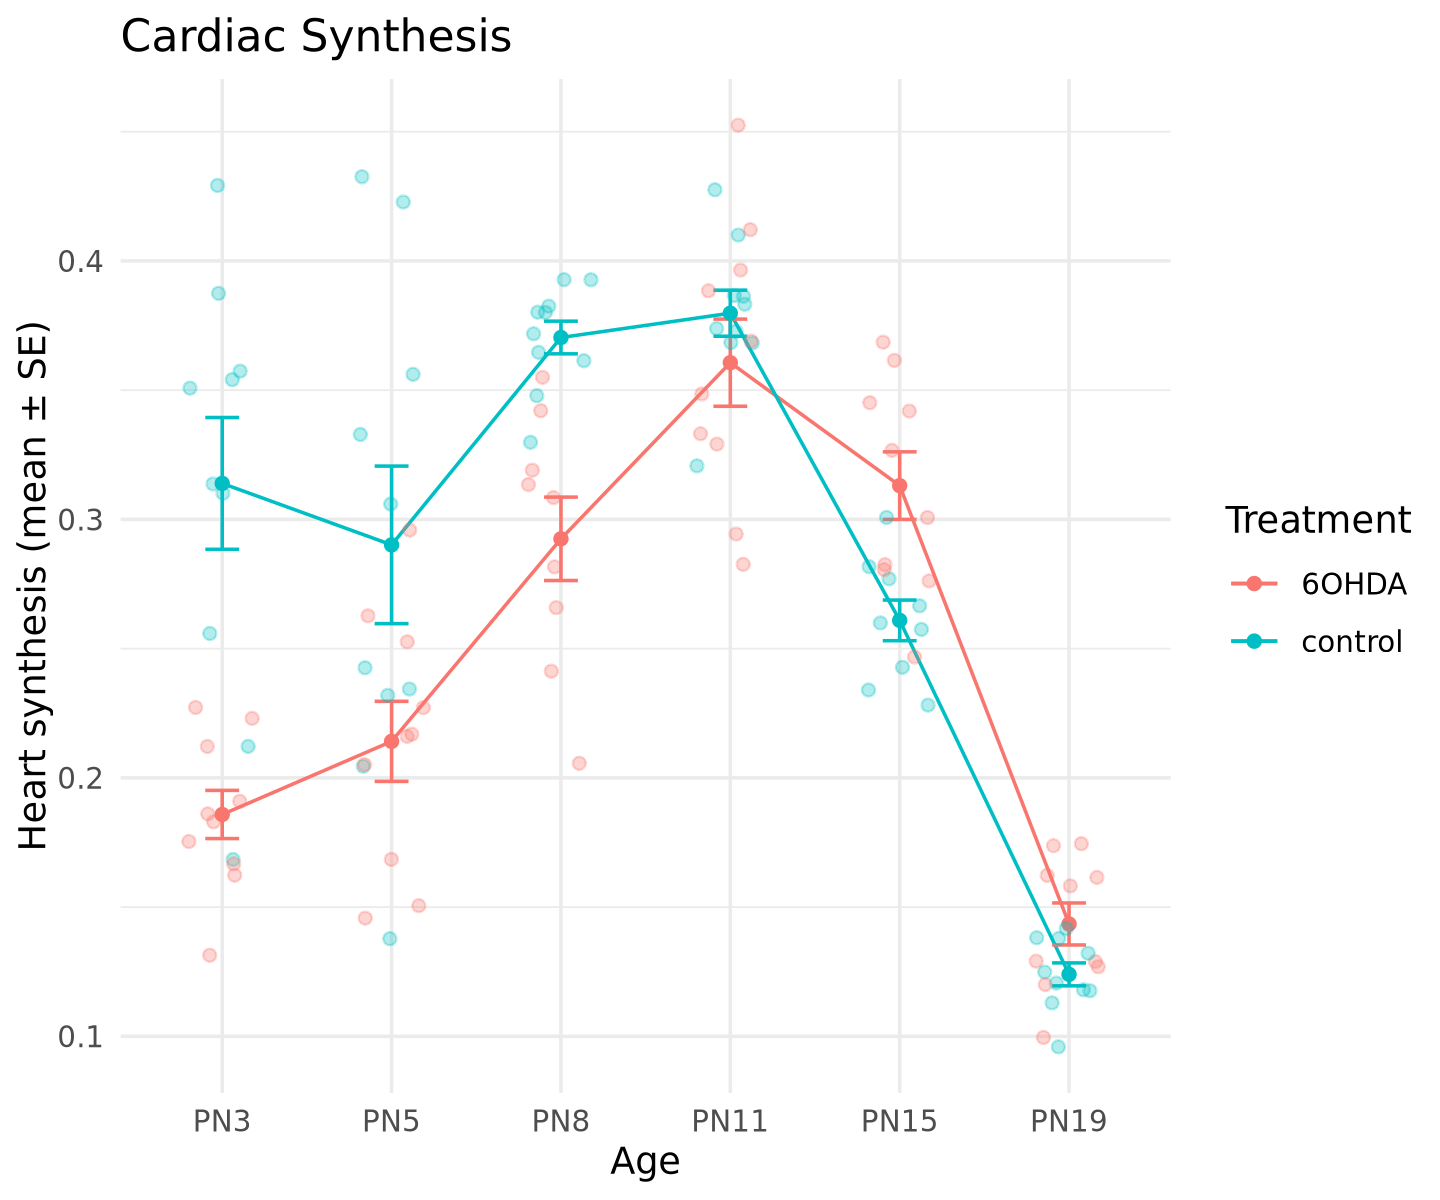

In [21]:
options(repr.plot.width = 6, repr.plot.height = 5, repr.plot.res=240)


data_vetted.df %>%
  filter(synthesis == "dna" , tissue == "heart") %>%
  ggplot(aes(x = age_factor, y = ratio, color = treatment, group = treatment)) +
  stat_summary(fun.data = mean_se, geom = "line") +
  stat_summary(fun.data = mean_se, geom = "errorbar", width = 0.2) +
  stat_summary(fun.data = mean_se, geom = "point") +
geom_point(alpha = 0.3, position = position_jitter(width = 0.2)) +
  theme_minimal() +
  labs(title = "Cardiac Synthesis",
       y = "Heart synthesis (mean ± SE)",
       x = "Age",
       color = "Treatment")

In [22]:
html_content<-readr::read_file("assets/html/activity_quiz.html")
display_html(html_content)

Does 6OHDA affect the mitotic activity of developing cardiac muscle cells?
 
 
 
 Yes
 
 
 No

When standard error (SE) bars do not overlap between two groups, it's a good indication that the difference is likely to be statistically significant at p < 0.05. Looking at our cardiac synthesis data, this suggests significant differences at PN3 and PN5 where the SE bars are clearly separated.

While this visual heuristic is useful for quick interpretation, we'll want to confirm with actual t-tests. However, since we're testing multiple time points, we'll need to consider multiple testing correction to avoid inflating our Type I error rate.

Let's generate the same analysis for Liver DNA synthesis

In [ ]:
# Enter your code here


<details>
<summary><strong>Hint:</strong> Click to expand</summary>

The code will be very similar - you'll just need to:
- Replace the tissue value with liver
- Update the plot title to reflect liver synthesis
- Update axis labels as needed

</details>



<details>
<summary><strong>Solution:</strong> Click to expand</summary>  

```r  
options(repr.plot.width = 6, repr.plot.height = 5, repr.plot.res=240)

# Liver DNA
data_vetted.df %>%
  filter(synthesis == "dna" , tissue == "liver") %>%
  ggplot(aes(x = age_factor, y = ratio, color = treatment, group = treatment)) +
  stat_summary(fun.data = mean_se, geom = "line") +
  stat_summary(fun.data = mean_se, geom = "errorbar", width = 0.2) +
  stat_summary(fun.data = mean_se, geom = "point") +
geom_point(alpha = 0.3, position = position_jitter(width = 0.2)) +
  coord_cartesian(ylim = c(0, NA)) +
  theme_minimal() +
  labs(title = "Liver Synthesis",
       y = "Liver synthesis (mean ± SE)",
       x = "Age",
       color = "Treatment")
```

</details>

<iframe
  src="quiz.html"
  width="100%"
  height="400px"
  frameborder="0">
</iframe>

# Introduction to t-tests and Multiple Testing Correction

## t-test Variants
When performing t-tests to compare groups (e.g., treatment vs control), you'll often see references to both Student's and Welch's t-tests. In practice:

- Welch's t-test has become the standard default in modern statistical software
- The term "t-test" usually refers to either variant without distinction
- Both tests typically produce very similar results in most biological datasets

## Multiple Testing Correction

When performing multiple t-tests on the same dataset (e.g., comparing treatment effects across different ages or tissues), we need to account for the increased probability of false positives. This is often called the multiple testing problem:

- Each t-test has a 5% chance of a false positive (at α = 0.05)
- With 20 tests, we expect 1 false positive by chance alone
- The more tests we perform, the more likely we are to find "significant" results by chance

### Bonferroni Correction
The Bonferroni correction is a straightforward method to control for multiple testing:
- Multiply each p-value by the number of tests performed
- Or divide your significance threshold (α) by the number of tests
- Example: With 10 tests, use α = 0.05/10 = 0.005 as the threshold

This correction is conservative but simple and widely accepted. While other methods exist (like Benjamini-Hochberg), Bonferroni is often preferred when:
- You have a relatively small number of planned comparisons
- Strong control of false positives is important
- You need a method that's easy to explain and interpret

## Implementation
In our analysis, we'll use rstatix's `t_test()` function, which:
- Uses Welch's t-test by default
- Allows easy application of Bonferroni correction
- Provides clear output for reporting results

In [23]:
data_vetted.df %>%
  filter(synthesis == "dna", tissue== "heart") %>%
  group_by(age_factor) %>%
  t_test(ratio ~ treatment)


,age_factor,.y.,group1,group2,n1,n2,statistic,df,p
,<fct>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,PN3,ratio,6OHDA,control,10,10,-4.720288,11.36337,0.000576
2,PN5,ratio,6OHDA,control,10,10,-2.223598,13.35607,0.044000
3,PN8,ratio,6OHDA,control,9,10,-4.493716,10.42688,0.001040
4,PN11,ratio,6OHDA,control,10,10,-1.003718,13.65325,0.333000
5,PN15,ratio,6OHDA,control,10,9,3.418287,14.54678,0.003960
6,PN19,ratio,6OHDA,control,10,10,2.105781,13.92251,0.053900


In [24]:
data_vetted.df %>%
  filter(synthesis == "dna", tissue == "heart") %>%
  group_by(age_factor) %>%
  t_test(ratio ~ treatment) %>%
  adjust_pvalue(method = "bonferroni")

age_factor,.y.,group1,group2,n1,n2,statistic,df,p,p.adj
<fct>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
PN3,ratio,6OHDA,control,10,10,-4.720288,11.36337,0.000576,0.003456
PN5,ratio,6OHDA,control,10,10,-2.223598,13.35607,0.044000,0.264000
PN8,ratio,6OHDA,control,9,10,-4.493716,10.42688,0.001040,0.006240
PN11,ratio,6OHDA,control,10,10,-1.003718,13.65325,0.333000,1.000000
PN15,ratio,6OHDA,control,10,9,3.418287,14.54678,0.003960,0.023760
PN19,ratio,6OHDA,control,10,10,2.105781,13.92251,0.053900,0.323400


The t-test has a key limitation here: it can only compare two groups at a time. For the cardiac synthesis data, understanding both age effect and treatment effect would require multiple t-tests:

1. Between treatments (control vs 6OHDA) at each age point:
   - PN3 control vs 6OHDA
   - PN5 control vs 6OHDA
   - And so on... (6 separate tests)

This approach has two main problems:
1. Multiple testing increases the chance of false positives
2. There's no way to assess how age and treatment interact in a single statistical test

ANOVA is more appropriate because it can:
1. Test all groups in a single statistical test
2. Directly examine both main effects (age, treatment) and their interaction
3. Tell us if the effect of treatment depends on age (which appears true in this data)

So while t-tests are useful for simple comparisons, ANOVA better captures the complexity of this experimental design in a single statistical test.

## Two-Way ANOVA: Testing Treatment Effects Across Age

A two-way ANOVA helps us understand how both treatment and age affect heart DNA synthesis, and importantly, whether the treatment effect changes with age. Using the formula `ratio ~ treatment * age_factor`, we test three hypotheses:

1. **Main Effect of Treatment (H₀)**
  - Null: No difference between treatment groups (averaged across ages)
  - Alternative: Treatment groups differ in their average ratio

2. **Main Effect of Age (H₀)**
  - Null: No difference between age groups (averaged across treatments)
  - Alternative: At least two age groups differ in their ratio

3. **Interaction Effect (Treatment × Age) (H₀)**
  - Null: Treatment effect is consistent across all ages
  - Alternative: Treatment effect varies with age

The `*` in our formula tells R to test both main effects and their interaction. Here's our ANOVA:

In [25]:
data_vetted.df %>%
  filter(synthesis == "dna", tissue == "heart") %>%
  aov(ratio ~ treatment * age_factor, data = .) %>%
  summary()

                      Df Sum Sq Mean Sq F value   Pr(>F)    
treatment              1 0.0459 0.04588  19.139 2.85e-05 ***
age_factor             5 0.6679 0.13358  55.726  < 2e-16 ***
treatment:age_factor   5 0.1121 0.02242   9.355 2.09e-07 ***
Residuals            106 0.2541 0.00240                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
1 observation deleted due to missingness

## Interpreting the Two-Way ANOVA Results

All three effects in our analysis are statistically significant (p < 0.05):

1. **Treatment Effect** (F(1,106) = 19.139, p < 0.0001)
   * Strong evidence that treatment affects heart DNA synthesis
   * The extremely low p-value (2.85e-05) indicates this effect is highly significant

2. **Age Effect** (F(5,106) = 55.726, p < 0.0001)
   * Very strong evidence that synthesis changes with age
   * The p-value (< 2e-16) shows this is the most significant factor in the model

3. **Treatment × Age Interaction** (F(5,106) = 9.355, p < 0.0001)
   * Strong evidence that treatment effect varies with age
   * The significant interaction (p = 2.09e-07) indicates that how the treatment affects DNA synthesis depends on age

Note: The output mentions "1 observation deleted due to missingness," indicating that one data point was excluded from the analysis due to missing values.

## Is the effect specific to the heart (i.e., not shared by the liver)?

### Repeated Measures ANOVA: Testing Tissue-Specific DNA Synthesis Patterns

### Data Preparation
Analysis restricted to DNA synthesis measurements to examine:
- How treatment affects synthesis across tissues
- Whether tissue responses vary with development
- If treatment effects are tissue-specific

### Data Structure
- Within-subject factor: tissue (heart vs. liver paired measurements)
- Between-subject factors:
 1. Treatment (control vs. 6OHDA)
 2. Age (all developmental timepoints)
- Subject identifier: animal_id

**Between-Subject Null Hypotheses:**
1. **Treatment Effect**: H₀: No difference in DNA synthesis between treated and control animals
2. **Age Effect**: H₀: No difference in DNA synthesis across developmental ages
3. **Treatment × Age**: H₀: Treatment effects are consistent across ages

**Within-Subject Null Hypotheses:**
1. **Tissue Effect**: H₀: No difference in DNA synthesis between heart and liver from same animals
2. **Tissue × Treatment**: H₀: Treatment effects are consistent between paired tissues
3. **Tissue × Age**: H₀: Developmental patterns are consistent between paired tissues
4. **Tissue × Treatment × Age**: H₀: Treatment effects on developmental patterns are consistent between paired tissues

**Statistical Design Considerations:**
- Repeated measures design accounts for paired tissue samples
- Type III sums of squares used by default
- Sphericity not a concern (only two tissue levels)
- Complete pairs required for each subject

In [26]:
# Run repeated measures ANOVA

data_vetted.df %>%
  filter(synthesis == "dna") %>%
  aov(ratio ~ treatment * age_factor * tissue + Error(animal_id/tissue), 
      data = .) %>%
  summary()



Error: animal_id
          Df Sum Sq Mean Sq
treatment  1 0.7662  0.7662

Error: animal_id:tissue
          Df   Sum Sq  Mean Sq
treatment  1 0.005875 0.005875

Error: Within
                             Df Sum Sq Mean Sq F value   Pr(>F)    
treatment                     1 0.0410  0.0410  11.776 0.000723 ***
age_factor                    5 0.2651  0.0530  15.245 9.09e-13 ***
tissue                        1 0.3825  0.3825 109.967  < 2e-16 ***
treatment:age_factor          5 0.0762  0.0152   4.381 0.000817 ***
treatment:tissue              1 0.0038  0.0038   1.088 0.298054    
age_factor:tissue             5 0.4301  0.0860  24.730  < 2e-16 ***
treatment:age_factor:tissue   5 0.0499  0.0100   2.870 0.015755 *  
Residuals                   209 0.7269  0.0035                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [27]:
html_content<-readr::read_file("assets/html/anova_quiz.html")
display_html(html_content)

Which effects address the question: Are the observed effects from 60HDA specific to heart?
 
 
 
 
 treatment 
 
 
 
 age_factor 
 
 
 
 tissue 
 
 
 
 treatment:age_factor 
 
 
 
 treatment:tissue 
 
 
 
 age_factor:tissue 
 
 
 
 treatment:age_factor:tissue 
 
 Submit

## Is the effect specific to DNA synthesis (ie not shared by protein synthesis)

### Three-Way ANOVA: Testing Effects of Treatment, Age, and Synthesis Type

**Factor-Level Null Hypotheses:**
1. **Treatment Effect**: H₀: No difference in synthesis ratios between treated and control animals
2. **Age Effect**: H₀: No difference in synthesis ratios across PN5, PN15, and PN19
3. **Synthesis Effect**: H₀: No difference between DNA and protein synthesis ratios

**Two-Way Interaction Null Hypotheses:**
1. **Treatment × Age**: H₀: The relationship between age and synthesis ratios is consistent across treatments
2. **Treatment × Synthesis**: H₀: The effect of treatment is consistent between DNA and protein synthesis
3. **Age × Synthesis**: H₀: Age-related changes are consistent between DNA and protein synthesis

**Three-Way Interaction Null Hypothesis:**
1. **Treatment × Age × Synthesis**: H₀: The effect of 6OHDA on synthesis ratios follows the same age-dependent pattern for both DNA and protein synthesis

**Statistical Design Requirements:**
- Complete pairs of measurements needed
- Balance assessed at each age point
- Type III sums of squares appropriate for slight imbalances

### Check for paired samples and balanced design


In [28]:
# Check balance of experimental design
data_vetted.df %>%
  filter(tissue == "heart") %>%
  group_by(age_factor, synthesis) %>%
  summarise(n = n(), .groups = "drop") %>%
  spread(synthesis, n)

age_factor,dna,protein
<fct>,<int>,<int>
PN3,20,NA
PN5,20,19
PN8,20,NA
PN11,20,NA
PN15,19,39
PN19,20,20


Initial data review shows synthesis measurements are not uniformly paired:

- PN3: DNA only (n=20)
- PN5: Both DNA (n=20) and protein (n=19)
- PN8: DNA only (n=20)
- PN11: DNA only (n=20)
- PN15: Both DNA (n=19) and protein (n=39)
- PN19: Both DNA (n=20) and protein (n=20)

Therefore, analysis needs to be restricted to ages with both measurements (PN5, PN15, PN19) to maintain valid comparisons.

In [29]:

data_vetted.df %>%
  filter(tissue == "heart",
         age_factor %in% c("PN5", "PN15", "PN19")) %>%
  aov(ratio ~ treatment * age_factor * synthesis, data = .) %>%
  summary()

                                Df Sum Sq Mean Sq  F value   Pr(>F)    
treatment                        1  0.014   0.014    6.494  0.01204 *  
age_factor                       2  0.583   0.292  133.526  < 2e-16 ***
synthesis                        1  5.426   5.426 2483.713  < 2e-16 ***
treatment:age_factor             2  0.175   0.088   40.118 3.48e-14 ***
treatment:synthesis              1  0.017   0.017    7.621  0.00664 ** 
age_factor:synthesis             2  0.242   0.121   55.428  < 2e-16 ***
treatment:age_factor:synthesis   2  0.025   0.013    5.749  0.00409 ** 
Residuals                      125  0.273   0.002                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [30]:
html_content<-readr::read_file("assets/html/anova3factor_quiz.html")
display_html(html_content)

Based on the ANOVA results, which terms tell us if the effect is specific to DNA synthesis (i.e., not shared by protein synthesis)?
 
 
 
 
 treatment (p=2.00e-03) 
 
 
 
 age_factor (p=3.89e-10) 
 
 
 
 synthesis (p=6.18e-84) 
 
 
 
 treatment:age_factor (p=4.55e-14) 
 
 
 
 treatment:synthesis (p=1.00e-03) 
 
 
 
 age_factor:synthesis (p=5.84e-18) 
 
 
 
 treatment:age_factor:synthesis (p=4.00e-03) 
 
 Submit

## Four-Way Mixed ANOVA: Testing Multi-Tissue Response to Treatment

The previous ANOVA's required separate tests to assess the tissue and synthesis specific effects which could lead to type I errors due to multiple hypothesis testing.  We can confirm these results in a single 4 way ANOVA test.

### Data Availability Assessment
Balanced design requirements:
- Only ages with both DNA and protein measurements included (PN5, PN15, PN19)
- Each animal (subject) has measurements for both tissues
- Animal_id used as subject identifier for repeated measures

**Between-Subject Null Hypotheses:**
1. **Treatment Effect**: H₀: No difference in synthesis ratios between treated and control animals
2. **Age Effect**: H₀: No difference in synthesis ratios across PN5, PN15, and PN19
3. **Synthesis Effect**: H₀: No difference between DNA and protein synthesis ratios
4. **Treatment × Age**: H₀: Treatment effects are consistent across ages
5. **Treatment × Synthesis**: H₀: Treatment effects are consistent between synthesis types
6. **Age × Synthesis**: H₀: Age effects are consistent between synthesis types
7. **Treatment × Age × Synthesis**: H₀: Two-way interactions are consistent across third factor

**Within-Subject Null Hypotheses:**
1. **Tissue Effect**: H₀: No difference in synthesis ratios between heart and liver
2. **Tissue × Treatment**: H₀: Tissue differences are consistent across treatments
3. **Tissue × Age**: H₀: Tissue differences are consistent across ages
4. **Tissue × Synthesis**: H₀: Tissue differences are consistent between synthesis types
5. **Three-Way Interactions with Tissue**: H₀: Two-way interactions are consistent across tissues
6. **Four-Way Interaction**: H₀: Three-way interactions are consistent across tissues

**Statistical Design Considerations:**
- Mixed design with repeated measures on tissue
- Type III sums of squares appropriate (default for repeated measures)
- Need to verify complete pairs across tissues

In [31]:
# Four-factor ANOVA (treatment × age × synthesis × tissue)
# with tissue as repeated measure


data_vetted.df %>%
  filter(age_factor %in% c("PN5", "PN15", "PN19")) %>%
  aov(ratio ~ treatment * age_factor * synthesis * tissue + 
      Error(animal_id/tissue), data = .) %>%
  summary()


Error: animal_id
          Df Sum Sq Mean Sq
treatment  1  7.283   7.283

Error: animal_id:tissue
       Df Sum Sq Mean Sq
tissue  1 0.1588  0.1588

Error: Within
                                       Df Sum Sq Mean Sq F value   Pr(>F)    
treatment                               1  0.217  0.2166  69.519 5.26e-15 ***
age_factor                              2  4.018  2.0091 644.935  < 2e-16 ***
synthesis                               1  0.916  0.9159 294.001  < 2e-16 ***
tissue                                  1  0.058  0.0578  18.561 2.37e-05 ***
treatment:age_factor                    2  0.094  0.0470  15.081 6.59e-07 ***
treatment:synthesis                     1  0.006  0.0059   1.908 0.168382    
age_factor:synthesis                    2  0.309  0.1543  49.528  < 2e-16 ***
treatment:tissue                        1  0.000  0.0000   0.011 0.917981    
age_factor:tissue                       2  0.087  0.0433  13.901 1.90e-06 ***
synthesis:tissue                        1  0.019  0.0194

In [32]:
html_content<-readr::read_file("assets/html/anova4factor_quiz.html")
display_html(html_content)

Which terms in the four-way ANOVA validate our prior tests on tissue and synthesis type specificity?
 
 
 
 
 treatment:synthesis (p=6.80e-02) 
 
 
 
 treatment:tissue (p=7.29e-01) 
 
 
 
 treatment:age_factor:synthesis (p=1.80e-02) 
 
 
 
 treatment:age_factor:tissue (p=3.82e-08) 
 
 
 
 treatment:synthesis:tissue (p=4.30e-02) 
 
 
 
 treatment:age_factor:synthesis:tissue (p=3.80e-01) 
 
 Submit

## What about body weight?  




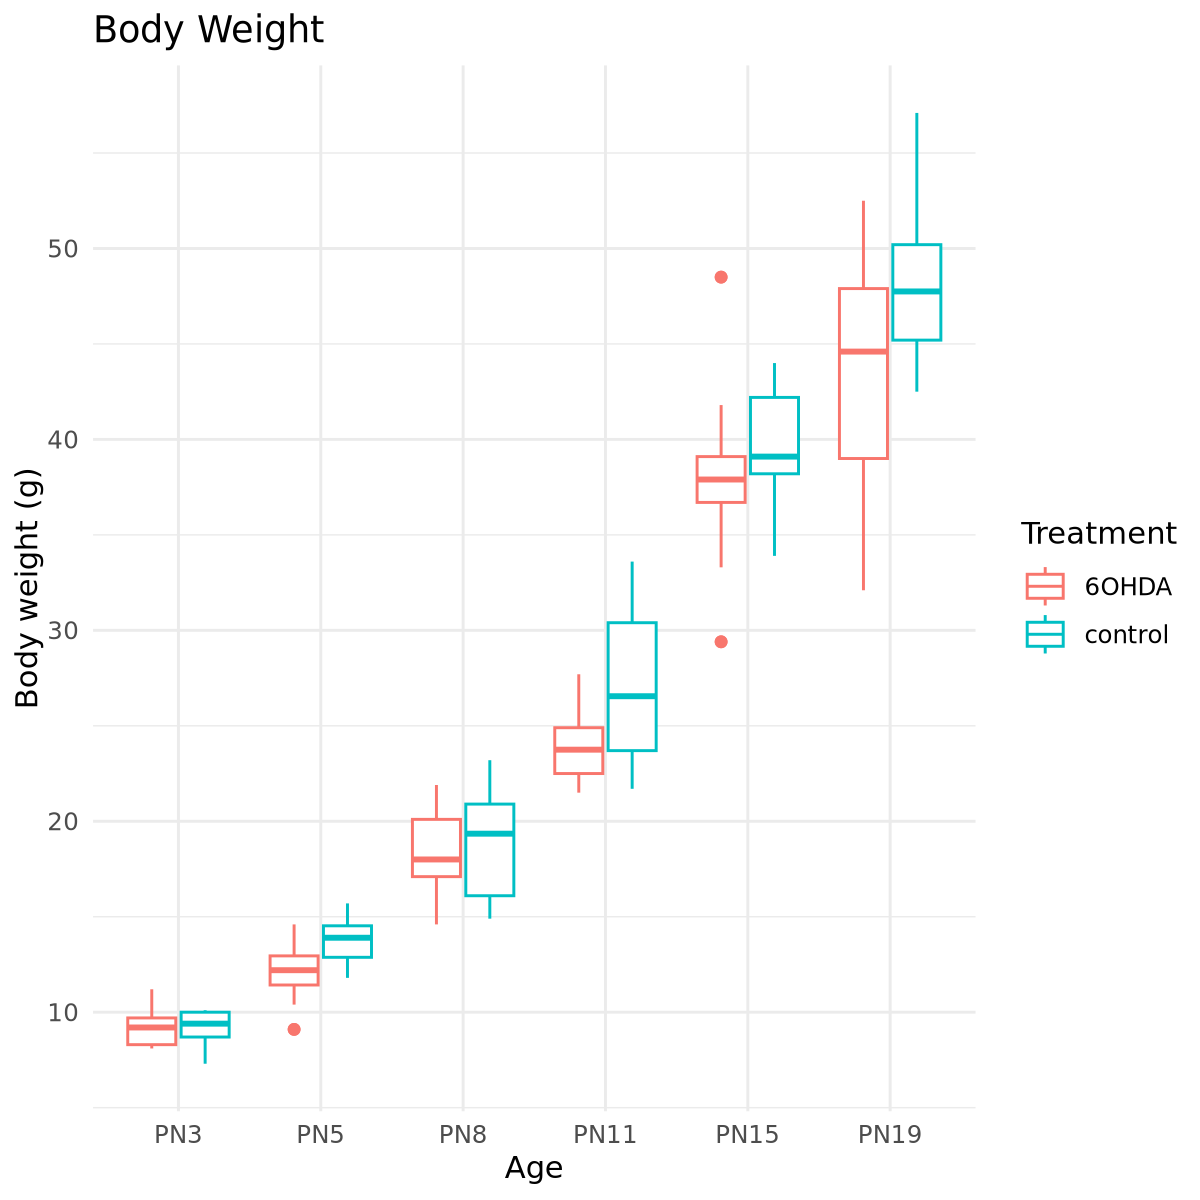

In [33]:
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res=200)

# Heart DNA
data_vetted.df %>%
  ggplot(aes(x = age_factor, y = body_weight_g, color = treatment)) +
  geom_boxplot() +
  theme_minimal() +
  labs(title = "Body Weight",
       x = "Age",
       y = "Body weight (g)",
       color = "Treatment")


In [34]:
# Perform a two factor ANOVA 

data_vetted.df %>%
  aov(log(body_weight_g) ~ treatment * age_factor, data = .) %>%
  summary()

                      Df Sum Sq Mean Sq  F value   Pr(>F)    
treatment              1   0.20   0.198   19.608 1.24e-05 ***
age_factor             5 129.43  25.885 2560.480  < 2e-16 ***
treatment:age_factor   5   0.15   0.029    2.876   0.0146 *  
Residuals            382   3.86   0.010                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

## Is body weight a predictor of cardiac or liver sythesis?

Plot body weight as a function of cardiac DNA synthesis


`geom_smooth()` using formula = 'y ~ x'


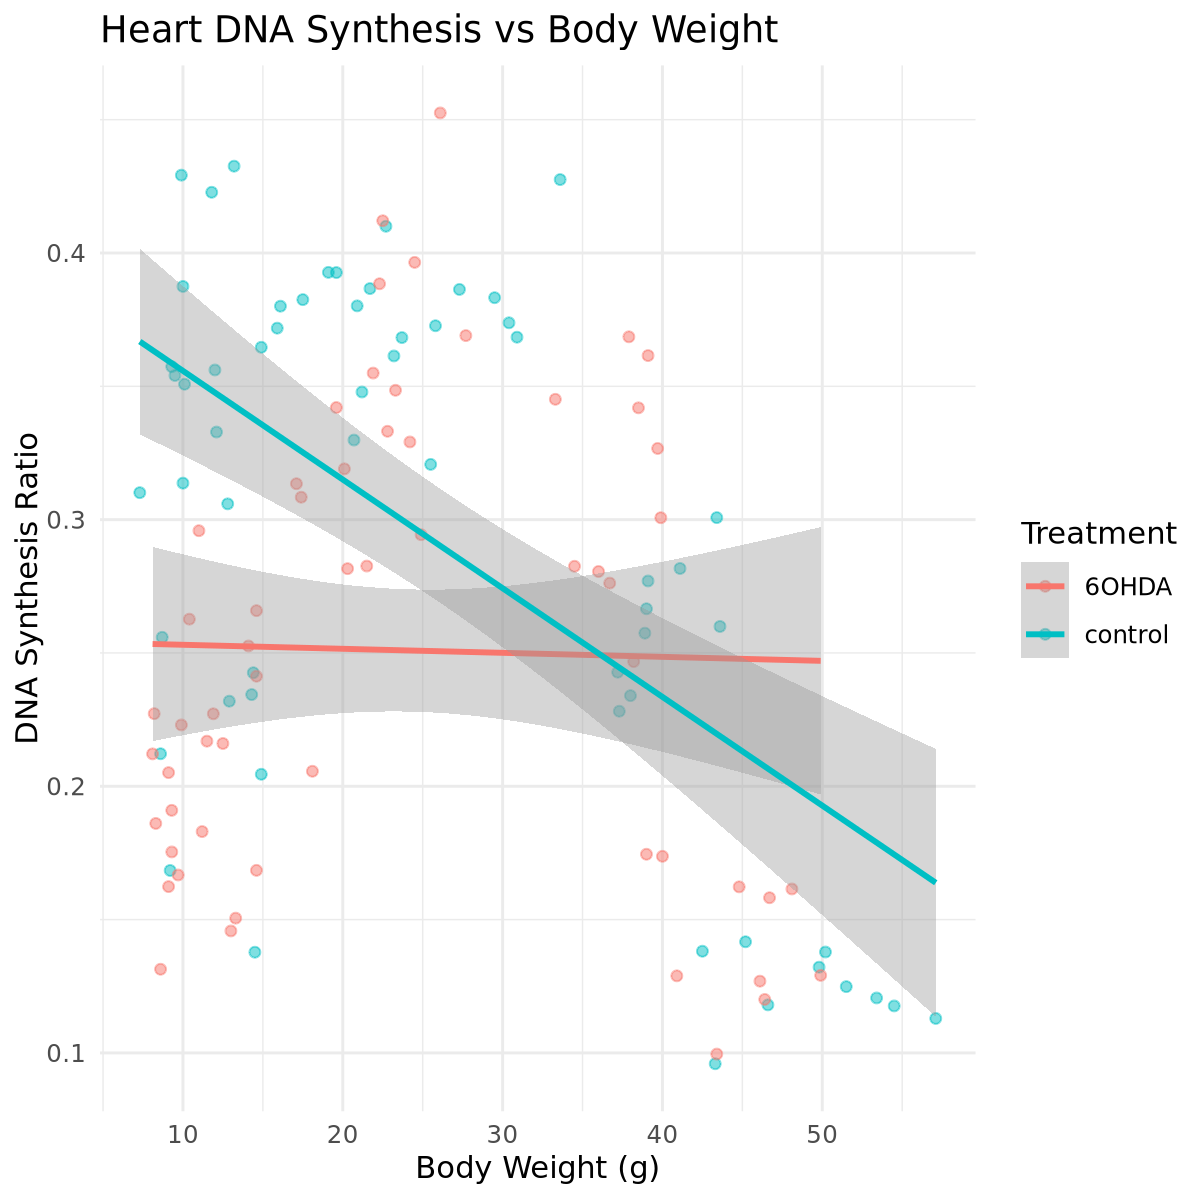

In [35]:
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res=200)

data_vetted.df %>%
 filter(synthesis == "dna", tissue == "heart") %>%
 ggplot(aes(x = body_weight_g, y = ratio, color = treatment)) +
 geom_point(alpha = 0.5) +
 geom_smooth(method = "lm", se = TRUE) +
 theme_minimal() +
 labs(title = "Heart DNA Synthesis vs Body Weight",
      x = "Body Weight (g)",
      y = "DNA Synthesis Ratio",
      color = "Treatment")




Plot body weight as a function of liver DNA synthesis


In [36]:
# Enter your code here


<details>
<summary><strong>Hint:</strong> Click to expand</summary>

The code will be very similar - you'll just need to:
- Replace tissue type with liver
- Update the plot title to reflect liver synthesis
- Update axis labels as needed

</details>



<details>
<summary><strong>Solution:</strong> Click to expand</summary>  

```r  
options(repr.plot.width = 6, repr.plot.height = 5, repr.plot.res=200)

# Liver DNA
data_vetted.df %>%
 filter(synthesis == "dna", tissue == "liver") %>%
 ggplot(aes(x = body_weight_g, y = ratio, color = treatment)) +
 geom_point(alpha = 0.5) +
 geom_smooth(method = "lm", se = TRUE) +
 theme_minimal() +
 labs(title = "Liver DNA Synthesis vs Body Weight",
      x = "Body Weight (g)",
      y = "DNA Synthesis Ratio",
      color = "Treatment")
```

</details>

In [37]:
#peform correlation tests on all the combinations
data_vetted.df %>%
  filter(synthesis == "dna") %>%
  group_by(tissue, treatment) %>%
  cor_test(body_weight_g, ratio) %>%
  arrange(tissue, treatment)  # Sort results

treatment,tissue,var1,var2,cor,statistic,p,conf.low,conf.high,method
<fct>,<fct>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
6OHDA,heart,body_weight_g,ratio,-0.023,-0.1731424,8.63e-01,-0.2773809,0.2345320,Pearson
control,heart,body_weight_g,ratio,-0.590,-5.5748437,7.07e-07,-0.7378563,-0.3985593,Pearson
6OHDA,liver,body_weight_g,ratio,-0.770,-9.0412119,1.55e-12,-0.8579388,-0.6392590,Pearson
control,liver,body_weight_g,ratio,-0.690,-7.0986383,2.18e-09,-0.8006387,-0.5201654,Pearson


# ANCOVA Analysis of Cardiac DNA Synthesis: Controlling for Body Weight Effects

## Research Question and Hypothesis
Can the effect of treatment (6OHDA) on cardiac DNA synthesis  be explained simply by changes in body weight. If the treatment's effect is solely due to reduced body weight, we would expect the relationship between body weight and DNA synthesis to be the same for both control and treated animals - just with treated animals being smaller.

## Statistical Approach
To test this, we use Analysis of Covariance (ANCOVA) which allows us to:
1. Control for body weight as a continuous variable (covariate)
2. Test if treatments differ after accounting for body weight
3. Most importantly, test if the relationship between body weight and DNA synthesis differs between treatments

The ANCOVA model tests three key hypotheses:
- Is there a relationship between body weight and DNA synthesis? (covariate effect)
- Do treatments differ in DNA synthesis when controlling for body weight? (treatment effect)
- Does the relationship between body weight and DNA synthesis differ between treatments? (interaction)

# ANCOVA Setup and Variable Specification

## Model Formula
`ratio ~ body_weight_g + treatment + treatment:body_weight_g`

## Variables
- **Dependent Variable (Y)**: ratio (DNA synthesis ratio, continuous)
- **Covariate (X)**: body_weight_g (continuous)
- **Treatment Factor**: treatment (categorical: control vs 6OHDA)
- **Interaction**: treatment:body_weight_g (tests if slopes differ between treatments)




In [38]:


# Heart tissue analysis
data_vetted.df %>%
  filter(synthesis == "dna", tissue == "heart") %>%
  aov(ratio ~ body_weight_g + treatment + treatment:body_weight_g, data = .) %>%
  summary()

# Liver tissue analysis
data_vetted.df %>%
  filter(synthesis == "dna", tissue == "liver") %>%
  aov(ratio ~ body_weight_g + treatment + treatment:body_weight_g, data = .) %>%
  summary()

                         Df Sum Sq Mean Sq F value   Pr(>F)    
body_weight_g             1 0.1132 0.11317  15.647 0.000133 ***
treatment                 1 0.0554 0.05544   7.665 0.006572 ** 
body_weight_g:treatment   1 0.0868 0.08679  11.999 0.000751 ***
Residuals               114 0.8246 0.00723                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
1 observation deleted due to missingness

                         Df Sum Sq Mean Sq F value  Pr(>F)    
body_weight_g             1 0.7413  0.7413  116.94 < 2e-16 ***
treatment                 1 0.0691  0.0691   10.90 0.00129 ** 
body_weight_g:treatment   1 0.0001  0.0001    0.01 0.92205    
Residuals               113 0.7163  0.0063                    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
2 observations deleted due to missingness

## Results and Interpretation

For heart tissue, our ANCOVA analysis reveals:

1. **Body Weight Effect** (F(1,114) = 15.647, p = 0.000133)
   * Significant relationship between body weight and DNA synthesis
   * Body weight explains a substantial portion of the variance (Sum Sq = 0.1132)
   * Confirms body weight is strongly related to DNA synthesis

2. **Treatment Effect** (F(1,114) = 7.665, p = 0.006572)
   * Significant difference between treatments after controlling for body weight
   * Treatment accounts for meaningful variance (Sum Sq = 0.0554)
   * Shows treatment affects DNA synthesis beyond weight changes

3. **Body Weight × Treatment Interaction** (F(1,114) = 11.999, p = 0.000751)
   * Significant interaction indicates different slopes between treatments
   * Interaction explains considerable variance (Sum Sq = 0.0868)
   * **Critical finding**: The relationship between body weight and DNA synthesis differs between treatments

For liver tissue, our ANCOVA analysis reveals:

1. **Body Weight Effect** (F(1,113) = 116.94, p < 2e-16)
   * Highly significant relationship between body weight and DNA synthesis
   * Body weight explains the largest portion of variance (Sum Sq = 0.7413)
   * Demonstrates body weight is strongly related to DNA synthesis in liver tissue

2. **Treatment Effect** (F(1,113) = 10.90, p = 0.00129)
   * Significant difference between treatments after controlling for body weight
   * Treatment explains meaningful variance (Sum Sq = 0.0691)
   * Indicates treatment affects liver DNA synthesis independent of weight

3. **Body Weight × Treatment Interaction** (F(1,113) = 0.01, p = 0.92205)
   * No significant interaction between body weight and treatment
   * Minimal variance explained (Sum Sq = 0.0001)
   * **Important note**: The relationship between body weight and DNA synthesis is consistent across treatments in liver tissue


## Conclusion
The significant interaction proves that body weight reduction alone cannot explain the treatment effect on cardiac DNA synthesis. If the treatment effect was simply due to reduced body weight, we would expect parallel regression lines (no interaction). Instead, we find that treatment fundamentally alters how DNA synthesis relates to body weight, indicating a more complex biological effect beyond simple growth reduction.